<a href="https://colab.research.google.com/github/AdabalaLakshmidharani/ML_Projects/blob/main/MOVIE_GENRE_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Genre Classification using TF-IDF and Naive Bayes** #
Aim is to build a machine learning model to predict the genre of a movie based on its plot summary or textual information. To achieve this, we will leverage natural language processing (NLP) techniques, specifically TF-IDF (Term Frequency-Inverse Document Frequency), in conjunction with the Naive Bayes classification algorithm.

The primary goal is to create a model that can automatically assign one or more genres to a movie based on the textual description provided. This can be valuable for categorizing and organizing movies in databases, recommendation systems, and content filtering.

# Importing Libraries #

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load Dataset #

In [2]:
# Load the training data
train_path = "/content/train_data.txt"
train_data = pd.read_csv(train_path, sep=':::', names=['Title', 'Genre', 'Description'], engine='python')

In [3]:
print(train_data.describe())

                                 Title    Genre  \
count                            33693    33693   
unique                           33693       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1     8492   

                                              Description  
count                                               33693  
unique                                              33630  
top      Grammy - music award of the American academy ...  
freq                                                    9  


In [4]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 33693 entries, 1 to 33693
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        33693 non-null  object
 1   Genre        33693 non-null  object
 2   Description  33693 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB
None


In [5]:
print(train_data.isnull().sum())

Title          0
Genre          0
Description    0
dtype: int64


In [6]:
# Load the test data
test_path = "/content/test_data.txt"
test_data = pd.read_csv(test_path, sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


# EDA & Visualization #

<ipython-input-7-a17b3d7dc09c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
<ipython-input-7-a17b3d7dc09c>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette='viridis')


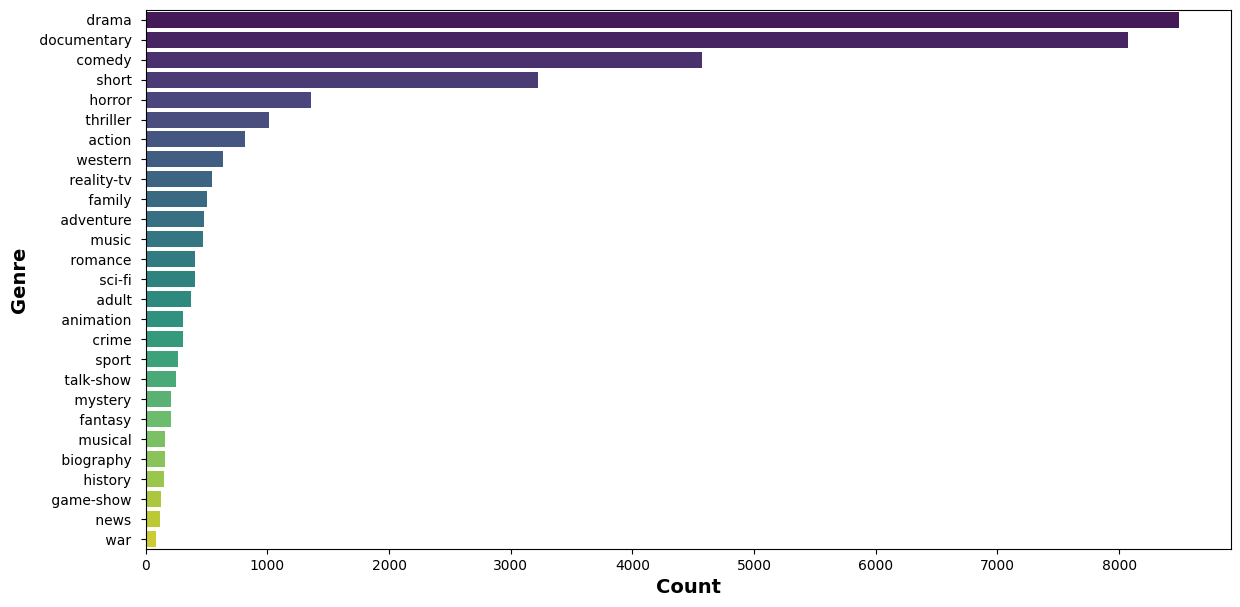

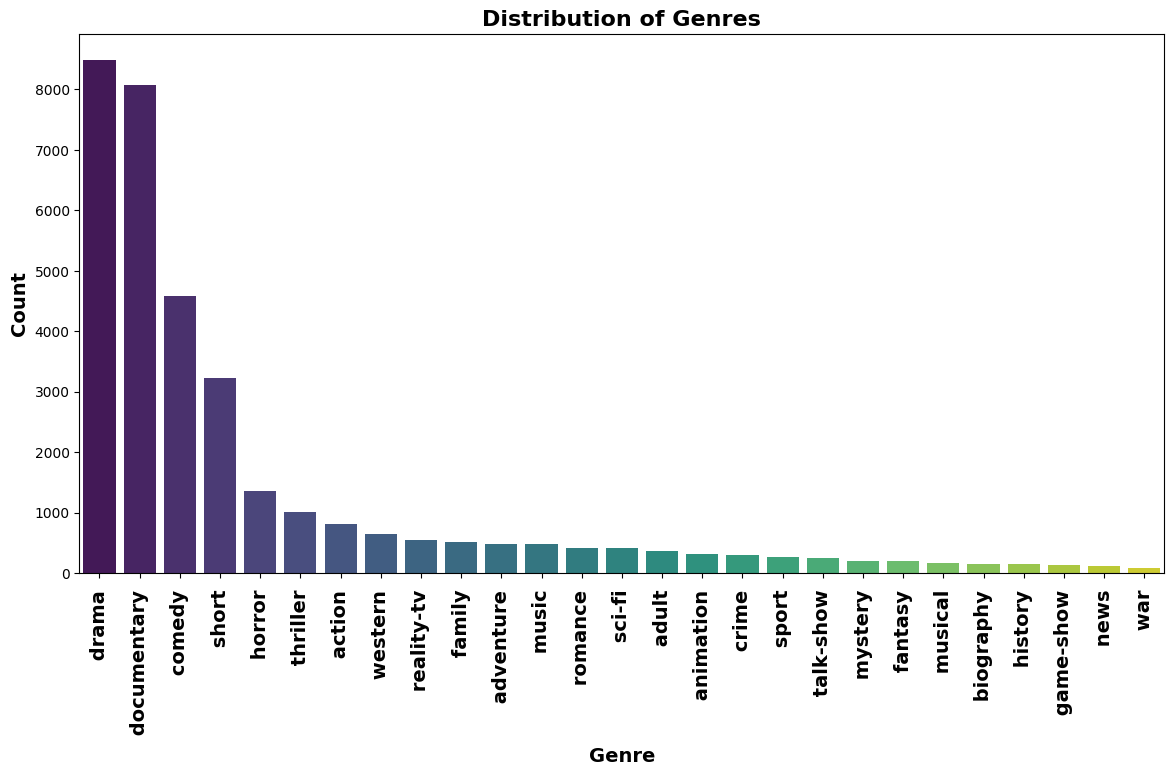

In [7]:
# Plot the distribution of genres in the training data
plt.figure(figsize=(14, 7))
sns.countplot(data=train_data, y='Genre', order=train_data['Genre'].value_counts().index, palette='viridis')
plt.xlabel('Count', fontsize=14, fontweight='bold')
plt.ylabel('Genre', fontsize=14, fontweight='bold')

# Plot the distribution of genres using a bar plot
plt.figure(figsize=(14, 7))
counts = train_data['Genre'].value_counts()
sns.barplot(x=counts.index, y=counts, palette='viridis')
plt.xlabel('Genre', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=16, fontweight='bold')
plt.xticks(rotation=90, fontsize=14, fontweight='bold')
plt.show()


#  Data Preprocessing and Text Cleaning #

In [8]:
!pip install nltk

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

# Continue Data Preprocessing #

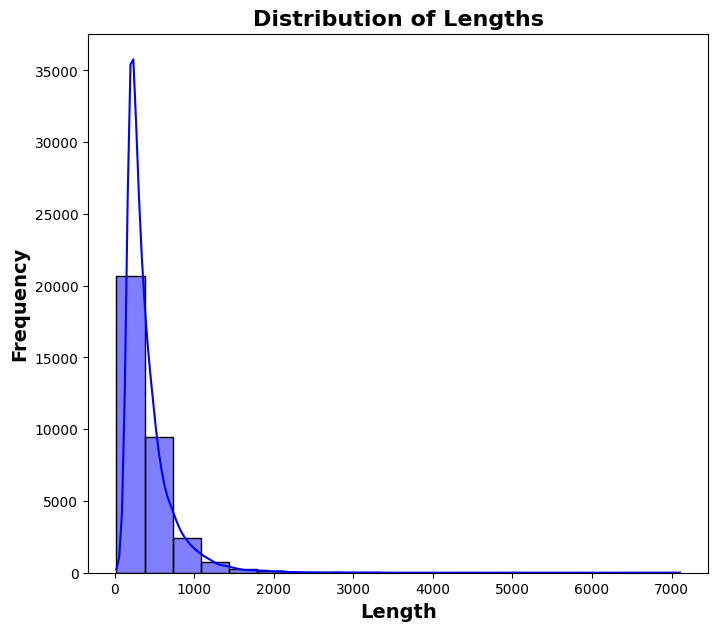

In [12]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()


#  Text Vectorization Using TF-IDF #

In [13]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])


#  Split Data and Train a Model (Naive Bayes) #

In [14]:
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = classifier.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)
print(classification_report(y_val, y_pred))


Validation Accuracy: 0.4378987980412524
               precision    recall  f1-score   support

      action        0.00      0.00      0.00       162
       adult        0.00      0.00      0.00        73
   adventure        0.00      0.00      0.00       100
   animation        0.00      0.00      0.00        66
   biography        0.00      0.00      0.00        40
      comedy        0.59      0.02      0.04       896
       crime        0.00      0.00      0.00        72
 documentary        0.54      0.90      0.68      1629
       drama        0.37      0.88      0.52      1667
      family        0.00      0.00      0.00       106
     fantasy        0.00      0.00      0.00        38
   game-show        0.00      0.00      0.00        28
     history        0.00      0.00      0.00        28
      horror        0.00      0.00      0.00       244
       music        0.00      0.00      0.00        91
     musical        0.00      0.00      0.00        26
     mystery        0.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 # Make Predictions on the Test Data #

In [15]:
# Use the trained model to make predictions on the test data
X_test_predictions = classifier.predict(X_test)
test_data['Predicted_Genre'] = X_test_predictions

In [17]:
# Save the test_data DataFrame with predicted genres to a CSV file
test_data.to_csv('/content/test_data.txt', index=False)

# Display the 'test_data' DataFrame with predicted genres
print(test_data)


          Id                                              Title  \
0          1                              Edgar's Lunch (1998)    
1          2                          La guerra de papá (1977)    
2          3                       Off the Beaten Track (2010)    
3          4                            Meu Amigo Hindu (2015)    
4          5                                 Er nu zhai (1955)    
...      ...                                                ...   
34340  34341   The Real Tom Thumb: History's Smallest Supers...   
34341  34342             "Le monde enchanté d'Isabelle" (1973)    
34342  34343                                Iron Forest (2008)    
34343  34344                                  Squatters (1996)    
34344  34345                    Europa: The Last Battle (2017)    

                                             Description  \
0       L.R. Brane loves his life - his car, his apar...   
1       Spain, March 1964: Quico is a very naughty ch...   
2       One yea